In [1]:
import os
import cv2
import csv
import numpy as np
!pip install mediapipe
import mediapipe as mp
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Инициализация MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False,
                      max_num_hands=1,
                      min_detection_confidence=0.5,
                      min_tracking_confidence=0.5)

# Создаем папку для результатов
os.makedirs('output_landmarks', exist_ok=True)
os.makedirs('output_visualization', exist_ok=True)

def process_video(video_path, output_csv, output_video):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Инициализация VideoWriter для визуализации
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    # Открываем CSV файл для записи landmarks
    with open(output_csv, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        # Заголовок CSV: frame_num + 21 landmarks (x,y,z) * 21
        header = ['frame_num']
        for i in range(21):
            header.extend([f'landmark_{i}_x', f'landmark_{i}_y', f'landmark_{i}_z'])
        csv_writer.writerow(header)

        frame_num = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Конвертация цвета и обработка
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(image)

            # Запись landmarks в CSV
            row = [frame_num]
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    # Записываем все 21 точки
                    for landmark in hand_landmarks.landmark:
                        row.extend([landmark.x, landmark.y, landmark.z])

                    # Визуализация на кадре
                    mp_drawing.draw_landmarks(
                        frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            else:
                # Если рука не обнаружена, заполняем нулями
                row.extend([0]*63)

            csv_writer.writerow(row)
            out.write(frame)
            frame_num += 1

    cap.release()
    out.release()

# Обрабатываем все видео в папке
video_folder = '/content/drive/MyDrive/videos3'
video_files = [f for f in os.listdir(video_folder) if f.endswith(('.mp4', '.avi', '.mov'))]

print(f"Найдено {len(video_files)} видео для обработки...")

for video_file in tqdm(video_files, desc="Обработка видео"):
    video_path = os.path.join(video_folder, video_file)
    base_name = os.path.splitext(video_file)[0]

    # Пути для выходных файлов
    output_csv = os.path.join('output_landmarks', f'{base_name}_landmarks.csv')
    output_video = os.path.join('output_visualization', f'{base_name}_visualized.mp4')

    process_video(video_path, output_csv, output_video)

print("Обработка завершена!")

In [ ]:
import os
from google.colab import files

# Создаем архив
!zip -r results3.zip output_landmarks/ output_visualization/

# Скачиваем
files.download('results3.zip')

In [4]:
import numpy as np
import pandas as pd
from scipy import signal

def load_landmarks(csv_path):
    """Загружает landmarks из CSV-файла."""
    df = pd.read_csv(csv_path)
    frames = df['frame_num'].values
    landmarks = df.drop(columns=['frame_num']).values.reshape(-1, 21, 3)  # (N, 21, 3)
    return frames, landmarks

In [5]:
def extract_features(landmarks, fps=30):
    """
    Извлекает признаки для одной руки:
    - rhythm: std интервалов между касаниями (мс)
    - speed: средняя скорость кончика пальца (пиксели/сек)
    - amplitude: нормированная амплитуда движения по Y
    """
    # Кончик указательного пальца (Landmark 8)
    fingertip = landmarks[:, 8, :2]  # Берем только X,Y
    y = fingertip[:, 1]  # Y-координата

    # Фильтрация
    b, a = signal.butter(3, 0.3, 'low')
    y_filt = signal.filtfilt(b, a, y)

    # Поиск пиков
    peaks, _ = signal.find_peaks(-y_filt, prominence=0.01)

    # 1. Ритм
    if len(peaks) >= 2:
        intervals = np.diff(peaks) / fps * 1000
        rhythm = np.std(intervals)
    else:
        rhythm = 0.0


    # 2. Скорость
    dx = np.diff(fingertip[:, 0])
    dy = np.diff(fingertip[:, 1])
    distance = np.sqrt(dx**2 + dy**2)
    speed = np.mean(distance) * fps  # Пикселей в секунду

    # 3. Амплитуда (нормированная на размер руки)
    wrist = landmarks[:, 0, :2]  # Landmark 0 - запястье
    hand_size = np.max(np.linalg.norm(wrist - landmarks[:, 5, :2], axis=1))  # Расстояние до MCP
    amplitude = (np.max(y) - np.min(y)) / np.median(hand_size)

    return {
        'rhythm_ms': rhythm,
        'speed_px_per_sec': speed,
        'amplitude_norm': amplitude,
        'num_taps': len(peaks)
    }

In [6]:
import os

def process_all_videos(input_dir, output_csv):
    """Обрабатывает все CSV в папке и сохраняет признаки."""
    features = []
    for csv_file in os.listdir(input_dir):
        if not csv_file.endswith('.csv'):
            continue

        # Загрузка данных
        frames, landmarks = load_landmarks(os.path.join(input_dir, csv_file))

        # Извлечение признаков
        feat = extract_features(landmarks)
        feat['video'] = csv_file.replace('_landmarks.csv', '')
        features.append(feat)

    # Сохранение в CSV
    pd.DataFrame(features).to_csv(output_csv, index=False)
    print(f"Результаты сохранены в {output_csv}")

# Пример вызова
process_all_videos('/content/drive/MyDrive/output_landmarks', 'hand_features3.csv')

Результаты сохранены в hand_features3.csv


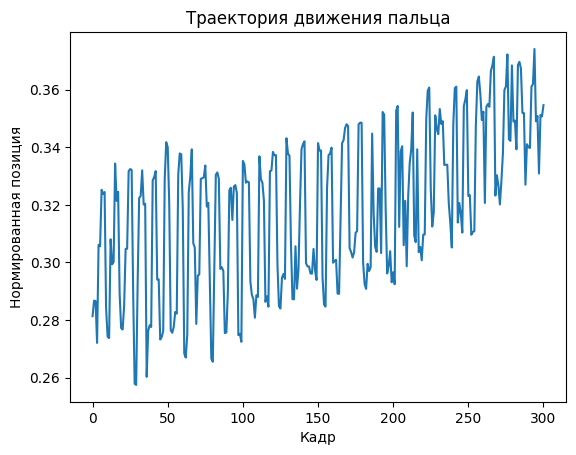

In [19]:
import matplotlib.pyplot as plt

def plot_movement(landmarks):
    """График движения пальца во времени."""
    fingertip = landmarks[:, 8, 1]  # Y-координата кончика пальца
    plt.plot(fingertip, label='Y-координата')
    plt.xlabel('Кадр')
    plt.ylabel('Нормированная позиция')
    plt.title('Траектория движения пальца')
    plt.show()

# Пример использования
_, landmarks = load_landmarks("/content/drive/MyDrive/output_landmarks/10004_11052025090223_e75ca698-34ee-11ed-b745-e82aea2c97f4_landmarks.csv")
plot_movement(landmarks)